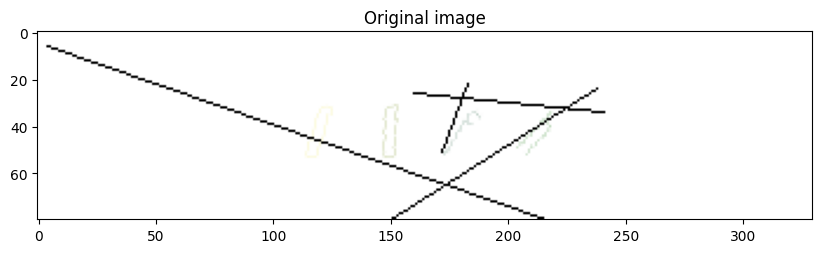

In [186]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read Image as RGB
image = cv2.imread("train/00fh-0.png")  

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title("Original image")
plt.show()

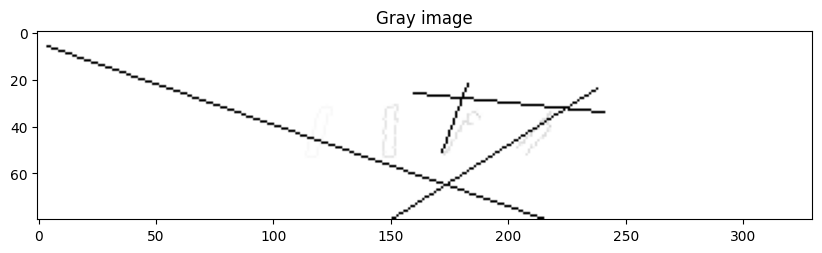

In [187]:
# Convert to Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

plt.title("Gray image")
plt.show()

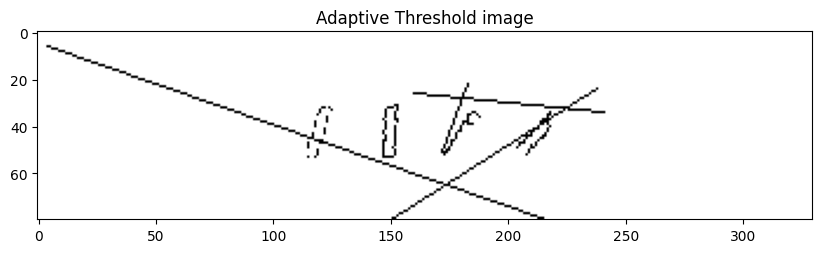

In [188]:
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 2)  # Magic numbers 145, 2

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

plt.title("Adaptive Threshold image")
plt.show()

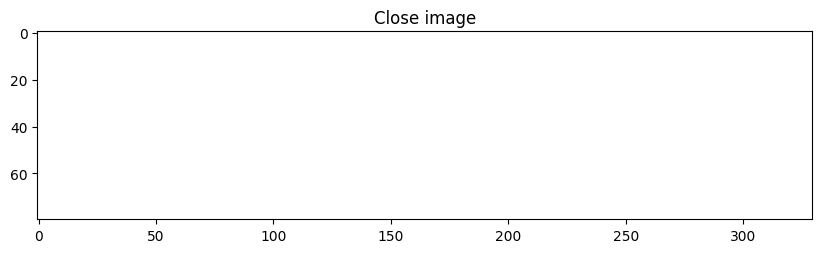

In [189]:
# Removes black lines
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((3,2), np.uint8))

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(cv2.cvtColor(close, cv2.COLOR_BGR2RGB))

plt.title("Close image")
plt.show()

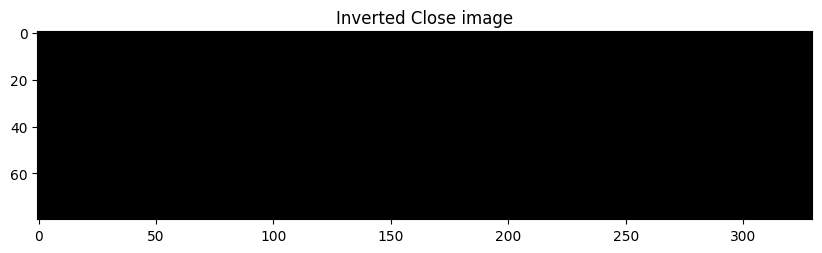

In [190]:
# Invert the image for contour in next step
close = cv2.bitwise_not(close)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(cv2.cvtColor(close, cv2.COLOR_BGR2RGB))

plt.title("Inverted Close image")
plt.show()

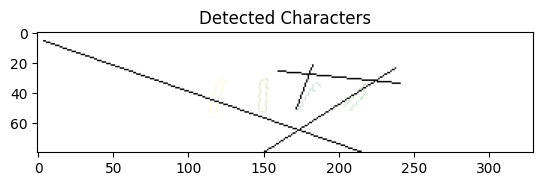

In [191]:
# Find contours (each detected object)
contours, _ = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Get outer contours & only the end-points of contours

# Draw bounding boxes around detected characters
output = image.copy()
char_boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Filter out small unwanted contours
    # if w > 5 and h > 20:  # Adjust values based on test results
    char_boxes.append((x, y, w, h))
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box

# Show image with detected characters
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Detected Characters")
plt.show()


# CAPTCHA traits in our dataset (for valid ones)
1. Noise (random black lines), we can remove using cv2.morphology
2. Overlapping characters, maybe can use watershed algorithm (see bottom of notebook)
3. Orientation (some characters are rotated), can train CNN with rotated images (data augmentation)
4. Thickness (some characters are thick, some are thin), only thin ones are the problem because cv2.morphology can treat them as noise (see weaknesses below)
5. Upper & lowercase, but final output is in lowercase (for baseline can just try mapping the uppercase in CAPTCHA to respective lowercase output)
6. Size (in some samples, characters are super big, while in others, characters are small), cv2.findcontours can handle as long as they remain connected, see 00o47-0.png
7. Font type (not everything is arial, some are even italics), hope CNN is smart enough to handle?

# Strengths
1. Can segment characters in images with much noise. See (0jpkca-0.png)

# Weaknesses
1. Faint images. See (00fh-0.png)
2. Characters have thin lines (around same thickness as noise). See (0a1gfi-0.png or 0i7o-0.png)
3. Overlapping characters. See (0axhfa-0.png)

# Separate characters by colors (not as good when I tried)
Idea is to remove all the black lines by color
1. Overcome thickness problem since we won't "mistakenly" remove characters with thin lines. Problem: black characters? Haven't found any yet.
2. Possible to overcome overlapping character problem since we identify them by color instead of outline. Problem: characters have same color lol, see 00fh-0.png 

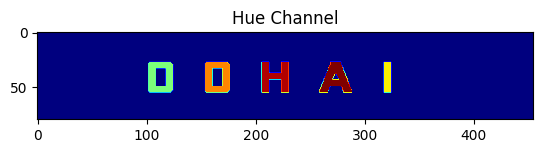

In [28]:
# Convert to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Split channels
hue, sat, val = cv2.split(hsv)

# Show the hue channel (colors)
plt.imshow(hue, cmap="jet")  # Jet colormap enhances color differences
plt.title("Hue Channel")
plt.show()


Estimated number of colors: 5


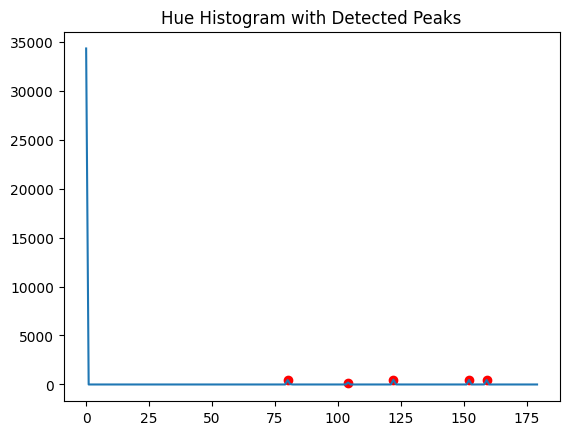

In [29]:
# Convert to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hue, _, _ = cv2.split(hsv)

# Compute histogram of Hue values
hist = cv2.calcHist([hue], [0], None, [180], [0, 180])

# Find peaks (local maxima) in histogram
from scipy.signal import find_peaks

peaks, _ = find_peaks(hist.ravel(), height=100)  # Adjust height if needed

print(f"Estimated number of colors: {len(peaks)}")
plt.plot(hist)
plt.scatter(peaks, hist[peaks], color="red")  # Mark detected peaks
plt.title("Hue Histogram with Detected Peaks")
plt.show()


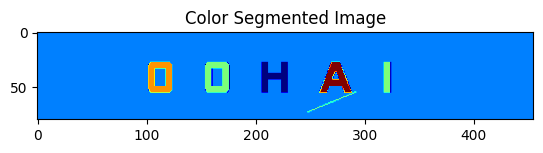

In [30]:
from sklearn.cluster import KMeans

# Reshape image to 2D array (each pixel = 3 values)
pixels = image.reshape(-1, 3)

# Apply k-means clustering (try 4-6 clusters)
kmeans = KMeans(n_clusters=len(peaks), n_init=10)  # Adjust clusters if needed
labels = kmeans.fit_predict(pixels)

# Reshape back to image shape
segmented = labels.reshape(image.shape[:2])

# Show color-segmented image
plt.imshow(segmented, cmap="jet")
plt.title("Color Segmented Image")
plt.show()


# Watershed algorithm to tackle overlapping problem
1. https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
2. Basically find the "center" of a character first
3. Then "flood" from the center to determine the point where a characters "ends" and stops overlapping
4. Some special algorithm that's better than BFS apparently (see link, bottom of the page)
5. Will attempt this until next meeting(?) unless there are higher priority things I should look at